In [1]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/enmodel/pytorch/default/1/best_model_en.pt
/kaggle/input/modelgeneral/pytorch/default/1/best_model.pt
/kaggle/input/modelbertde/pytorch/default/1/best_model_de_bert.pt
/kaggle/input/amazon-reviews/validation.csv
/kaggle/input/amazon-reviews/train.csv
/kaggle/input/amazon-reviews/test.csv
/kaggle/input/modelde/pytorch/default/1/best_model_de.pt
/kaggle/input/esmodel/pytorch/default/1/best_model_es.pt
/kaggle/input/modeldistilbertde/pytorch/default/1/best_model_de_distil_bert.pt


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import nltk

# Reading Data and Preprocesing

In [2]:
import pandas as pd

train_path = '/kaggle/input/amazon-reviews/train.csv'
test_path = '/kaggle/input/amazon-reviews/test.csv'
val_path = '/kaggle/input/amazon-reviews/validation.csv'

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)
df_val = pd.read_csv(val_path)

print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)
print("Validation shape:", df_val.shape)

Train shape: (1200000, 9)
Test shape: (30000, 9)
Validation shape: (30000, 9)


In [4]:
df_train.head()

,Unnamed: 0,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,0,de_0203609,product_de_0865382,reviewer_de_0267719,1,Armband ist leider nach 1 Jahr kaputt gegangen,Leider nach 1 Jahr kaputt,de,sports
1,1,de_0559494,product_de_0678997,reviewer_de_0783625,1,In der Lieferung war nur Ein Akku!,EINS statt ZWEI Akkus!!!,de,home_improvement
2,2,de_0238777,product_de_0372235,reviewer_de_0911426,1,"Ein Stern, weil gar keine geht nicht. Es hande...",Achtung Abzocke,de,drugstore
3,3,de_0477884,product_de_0719501,reviewer_de_0836478,1,"Dachte, das wären einfach etwas festere Binden...",Zu viel des Guten,de,drugstore
4,4,de_0270868,product_de_0022613,reviewer_de_0736276,1,Meine Kinder haben kaum damit gespielt und nac...,Qualität sehr schlecht,de,toy


In [5]:
df_val.head()

,Unnamed: 0,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,0,de_0591095,product_de_0301773,reviewer_de_0787123,1,Das Produkt kam bis heute nicht bei mir an. Ic...,Produkte NICHT geliefert,de,toy
1,1,de_0987834,product_de_0720578,reviewer_de_0983846,1,"Gebrauchte Spinner, teilzerlegt und teilweise ...","Gebrauchtware, ekelhaft",de,toy
2,2,de_0978206,product_de_0499114,reviewer_de_0238704,1,Bei beiden Bestellungen war jeweils eine Glühb...,Sehr schlechte Qualität,de,home
3,3,de_0407600,product_de_0648552,reviewer_de_0102048,1,Sofort zurückgeschickt,Der letzte Dreck,de,furniture
4,4,de_0453469,product_de_0900029,reviewer_de_0862313,1,wie man auf den Fotos erkennen kann ist das Gl...,"passform schlecht, Haftung schlecht - Finger weg",de,wireless


In [3]:
df_test.head()

,Unnamed: 0,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,0,de_0784695,product_de_0572654,reviewer_de_0645436,1,"Leider, leider nach einmal waschen ausgebliche...",Leider nicht zu empfehlen,de,home
1,1,de_0759207,product_de_0567331,reviewer_de_0183703,1,zunächst macht der Anker Halter einen soliden ...,Gummierung nach 6 Monaten kaputt,de,wireless
2,2,de_0711785,product_de_0482105,reviewer_de_0182152,1,Siegel sowie Verpackung war beschädigt und war...,Flohmarkt ware,de,industrial_supplies
3,3,de_0964430,product_de_0616480,reviewer_de_0991563,1,Habe dieses Produkt NIE erhalten und das Geld ...,Katastrophe,de,industrial_supplies
4,4,de_0474538,product_de_0228702,reviewer_de_0316188,1,Die Träger sind schnell abgerissen,Reißverschluss klemmt,de,luggage


In [5]:
def clean_and_check_nulls(df, name="Dataset"):
    original_len = len(df)
    df = df.dropna(subset=['review_title'])
    dropped = original_len - len(df)
    print(f"{name}: Dropped {dropped} rows with null 'review_title'.")
    
    remaining_nulls = df.isnull().sum()
    if remaining_nulls.sum() == 0:
        print(f"{name}: No remaining nulls.")
    else:
        print(f"{name}: Remaining null values:\n{remaining_nulls[remaining_nulls > 0]}")
    
    return df

In [6]:
def preprocess_data(df):
    df = clean_and_check_nulls(df);   
    df['review'] = df.apply(
        lambda x: f"CATEGORY: {x['product_category']}\nTITLE: {x['review_title']}\nREVIEW TEXT: {x['review_body']}",
        axis=1
    )
    
    df = df[df['language'].isin(['en', 'de', 'es'])] 
    df = df[df['stars'] != 3] 
    df["label"] = df["stars"].apply(lambda x: 1 if x >= 4 else 0)
  
    df_en = df[df['language'] == 'en']
    df_de = df[df['language'] == 'de']
    df_es = df[df['language'] == 'es']
    
    return df, df_en, df_de, df_es

In [7]:
# Preprocess train set
df_train, df_train_en, df_train_de, df_train_es = preprocess_data(df_train)
df_train = df_train[["review", "label"]]
print("Train shape:", df_train.shape)

df_train_en = df_train_en[["review", "label"]]
print("Train EN shape:", df_train_en.shape)

df_train_de = df_train_de[["review", "label"]]
print("Train DE shape:", df_train_de.shape)

df_train_es = df_train_es[["review", "label"]]
print("Train ES shape:", df_train_es.shape)

Dataset: Dropped 43 rows with null 'review_title'.
Dataset: No remaining nulls.


/tmp/ipykernel_35/2242070053.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['review'] = df.apply(


Train shape: (479978, 2)
Train EN shape: (159978, 2)
Train DE shape: (160000, 2)
Train ES shape: (160000, 2)


In [8]:
# Preprocess validation set
df_val, df_val_en, df_val_de, df_val_es = preprocess_data(df_val)
df_val = df_val[["review", "label"]]
print("Validation shape:", df_val.shape)

df_val_en = df_val_en[["review", "label"]]
print("Validation EN shape:", df_val_en.shape)

df_val_de = df_val_de[["review", "label"]]
print("Validation DE shape:", df_val_de.shape)

df_val_es = df_val_es[["review", "label"]]
print("Validation ES shape:", df_val_es.shape)


Dataset: Dropped 2 rows with null 'review_title'.
Dataset: No remaining nulls.
Validation shape: (11998, 2)
Validation EN shape: (3999, 2)
Validation DE shape: (3999, 2)
Validation ES shape: (4000, 2)


/tmp/ipykernel_35/2242070053.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['review'] = df.apply(


In [9]:
# Preprocess test set
df_test, df_test_en, df_test_de, df_test_es = preprocess_data(df_test)
df_test = df_test[["review", "label", "product_category", "language"]]
print("Test shape:", df_test.shape)

df_test_en = df_test_en[["review", "label", "product_category", "language"]]
print("Test EN shape:", df_test_en.shape)

df_test_de = df_test_de[["review", "label", "product_category", "language"]]
print("Test DE shape:", df_test_de.shape)

df_test_es = df_test_es[["review", "label", "product_category", "language"]]
print("Test ES shape:", df_test_es.shape)

Dataset: Dropped 1 rows with null 'review_title'.
Dataset: No remaining nulls.
Test shape: (11999, 4)
Test EN shape: (3999, 4)
Test DE shape: (4000, 4)
Test ES shape: (4000, 4)


/tmp/ipykernel_35/2242070053.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['review'] = df.apply(


# Model

In [ ]:
import os
os.environ["TRANSFORMERS_NO_TF"] = "1"

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score
import torch.nn.functional as F
from tqdm import tqdm
from transformers import DataCollatorWithPadding
from sklearn.metrics import accuracy_score, f1_score
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference
from datasets import Dataset
from torch.cuda.amp import GradScaler, autocast

2025-05-29 10:28:34.292307: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748514514.528138      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748514514.595238      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [12]:
# Configuration
model_name = "xlm-roberta-base"
num_epochs = 3
learning_rate = 2e-4
weight_decay = 0.01
batch_size = 256
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [ ]:

def prepare_datasets(df_train, df_val, df_test):
    train_dataset = Dataset.from_pandas(df_train.reset_index(drop=True))
    train_dataset = train_dataset.map(lambda e: tokenizer(e["review"], truncation=True, padding="max_length", max_length=512), batched=True)
    train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
    
    val_dataset = Dataset.from_pandas(df_val.reset_index(drop=True))
    val_dataset = val_dataset.map(lambda e: tokenizer(e["review"], truncation=True, padding="max_length",max_length=512), batched=True)
    val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
    
    test_dataset = Dataset.from_pandas(df_test.reset_index(drop=True))
    test_dataset = test_dataset.map(
        lambda e: tokenizer(e["review"], truncation=True, padding="max_length", max_length=512),
        batched=True
    )
    test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label", "language"])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=data_collator)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=data_collator)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, val_loader, test_loader

In [ ]:
def prepare_model():
    model = AutoModelForSequenceClassification.from_pretrained(model_name, 
                                                               num_labels=2
                                                              ).to(device)
    for param in model.base_model.parameters():
        param.requires_grad = False
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(name)
    return model

In [ ]:
def train_model(model, train_loader, val_loader, EPOCHS, save_path):
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    criterion = torch.nn.CrossEntropyLoss()
    scaler = GradScaler()
    
    best_f1 = 0.0
    
    for epoch in range(EPOCHS): 
        model.train()
        total_loss = 0
        loop = tqdm(train_loader, desc=f"Epoch {epoch + 1}")
        # Train
        for batch in loop:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
    
            optimizer.zero_grad()
            
            with autocast():  # AMP context
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
    
            # AMP scaling for safe backprop
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
    
            total_loss += loss.item()
            loop.set_postfix(loss=loss.item())
    
        print(f"Epoch {epoch + 1} - Training loss: {total_loss / len(train_loader):.4f}")
    
        # Validation
        model.eval()
        all_preds, all_labels = [], []
    
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
    
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                preds = torch.argmax(outputs.logits, dim=-1)
    
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
    
        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds)
    
        print(f"Epoch {epoch + 1} - Loss: {total_loss / len(train_loader):.4f} | Val Acc: {acc:.4f} | Val F1: {f1:.4f}")
    
        if f1 > best_f1:
            best_f1 = f1
            torch.save(model.state_dict(), save_path)
            print(f"Best model saved (F1: {f1:.4f})")

In [19]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    classification_report
)
def compute_group_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    TN, FP, FN, TP = cm.ravel()

    total = TP + FP + TN + FN
    selection_rate = (TP + FP) / total if total > 0 else 0
    sapmoc_accuracy = (TP + TN) / total if total > 0 else 0

    stat_parity_pos = selection_rate
    stat_parity_neg = (TN + FN) / total if total > 0 else 0

    eq_opp_pos = TP / (TP + FN) if (TP + FN) > 0 else 0
    eq_opp_neg = TN / (TN + FP) if (TN + FP) > 0 else 0

    calib_pos = TP / (TP + FP) if (TP + FP) > 0 else 0
    calib_neg = TN / (TN + FN) if (TN + FN) > 0 else 0

    cue_pos = FP / (TP + FP) if (TP + FP) > 0 else 0
    cue_neg = FN / (TN + FN) if (TN + FN) > 0 else 0

    treat_eq_pos = FP / FN if FN > 0 else float('inf')
    treat_eq_neg = FN / FP if FP > 0 else float('inf')

    return {
        'selection_rate': selection_rate,
        'sapmoc_accuracy': sapmoc_accuracy,
        'stat_parity_pos': stat_parity_pos,
        'stat_parity_neg': stat_parity_neg,
        'eq_opp_pos': eq_opp_pos,
        'eq_opp_neg': eq_opp_neg,
        'calib_pos': calib_pos,
        'calib_neg': calib_neg,
        'cue_pos': cue_pos,
        'cue_neg': cue_neg,
        'treat_eq_pos': treat_eq_pos,
        'treat_eq_neg': treat_eq_neg,
        'accuracy': accuracy_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred)
    }

def test_model(model, test_loader):
    all_preds, all_labels, group_labels = [], [], []

    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            languages = batch['language']

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=-1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            group_labels.extend(languages)

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    group_labels = np.array(group_labels)

    print("Overall Accuracy:", accuracy_score(all_labels, all_preds))
    print("Overall F1 Score:", f1_score(all_labels, all_preds))
    print("\\nClassification Report:\\n", classification_report(all_labels, all_preds))

    print("\\n--- Per-Language Metrics ---")
    for lang in np.unique(group_labels):
        idx = group_labels == lang
        y_true = all_labels[idx]
        y_pred = all_preds[idx]

        metrics = compute_group_metrics(y_true, y_pred)
        print(f"\\nLanguage: {lang}")
        for k, v in metrics.items():
            print(f"  {k.replace('_', ' ').capitalize()}: {v:.4f}")

    return all_labels, all_preds

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(all_labels, all_preds):
    cm = confusion_matrix(all_labels, all_preds)
    labels = ['Negative', 'Positive'] 
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', values_format='d')
    plt.title("Confusion Matrix")
    plt.show()
    

## All Languages

In [21]:
train_loader, val_loader, test_loader = prepare_datasets(df_train, df_val, df_test)

Map:   0%|          | 0/479978 [00:00<?, ? examples/s]

Map:   0%|          | 0/11998 [00:00<?, ? examples/s]

Map:   0%|          | 0/11999 [00:00<?, ? examples/s]

In [22]:
model = prepare_model()

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


classifier.dense.weight
classifier.dense.bias
classifier.out_proj.weight
classifier.out_proj.bias


In [23]:
train_model(model, train_loader, val_loader, 3, "./best_model.pt")

/tmp/ipykernel_35/2428646582.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1:   0%|          | 0/1875 [00:00<?, ?it/s]/tmp/ipykernel_35/2428646582.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # AMP context
Epoch 1: 100%|██████████| 1875/1875 [1:04:31<00:00,  2.07s/it, loss=0.459]


Epoch 1 - Training loss: 0.4818
Epoch 1 - Loss: 0.4818 | Val Acc: 0.8702 | Val F1: 0.8686
Best model saved (F1: 0.8686)


Epoch 2:   0%|          | 0/1875 [00:00<?, ?it/s]/tmp/ipykernel_35/2428646582.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # AMP context
Epoch 2: 100%|██████████| 1875/1875 [1:04:48<00:00,  2.07s/it, loss=0.445]


Epoch 2 - Training loss: 0.4584
Epoch 2 - Loss: 0.4584 | Val Acc: 0.8714 | Val F1: 0.8716
Best model saved (F1: 0.8716)


Epoch 3:   0%|          | 0/1875 [00:00<?, ?it/s]/tmp/ipykernel_35/2428646582.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # AMP context
Epoch 3: 100%|██████████| 1875/1875 [1:04:48<00:00,  2.07s/it, loss=0.413]


Epoch 3 - Training loss: 0.4460
Epoch 3 - Loss: 0.4460 | Val Acc: 0.8718 | Val F1: 0.8734
Best model saved (F1: 0.8734)


In [23]:
model.load_state_dict(torch.load("/kaggle/input/modelgeneral/pytorch/default/1/best_model.pt"))

<All keys matched successfully>

In [25]:
all_labels, all_preds = test_model(model, test_loader)

Overall Accuracy: 0.8744062005167097
Overall F1 Score: 0.8763233483791547
\nClassification Report:\n               precision    recall  f1-score   support

           0       0.89      0.86      0.87      5999
           1       0.86      0.89      0.88      6000

    accuracy                           0.87     11999
   macro avg       0.87      0.87      0.87     11999
weighted avg       0.87      0.87      0.87     11999

\n--- Per-Language Metrics ---
\nLanguage: de
  Selection rate: 0.4958
  Sapmoc accuracy: 0.8928
  Stat parity pos: 0.4958
  Stat parity neg: 0.5042
  Eq opp pos: 0.8885
  Eq opp neg: 0.8970
  Calib pos: 0.8961
  Calib neg: 0.8894
  Cue pos: 0.1039
  Cue neg: 0.1106
  Treat eq pos: 0.9238
  Treat eq neg: 1.0825
  Accuracy: 0.8928
  F1: 0.8923
\nLanguage: en
  Selection rate: 0.5239
  Sapmoc accuracy: 0.8517
  Stat parity pos: 0.5239
  Stat parity neg: 0.4761
  Eq opp pos: 0.8755
  Eq opp neg: 0.8279
  Calib pos: 0.8358
  Calib neg: 0.8692
  Cue pos: 0.1642
  Cue neg

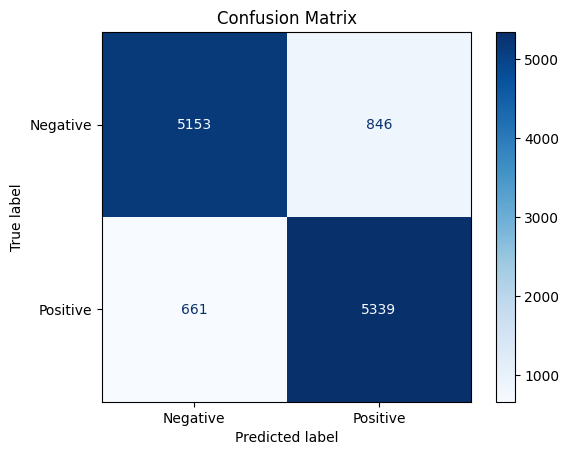

In [26]:
plot_confusion_matrix(all_labels, all_preds)

## English

In [30]:
train_loader_en, val_loader_en, test_loader_en = prepare_datasets(df_train_en, df_val_en, df_test_en)

Map:   0%|          | 0/159978 [00:00<?, ? examples/s]

Map:   0%|          | 0/3999 [00:00<?, ? examples/s]

Map:   0%|          | 0/3999 [00:00<?, ? examples/s]

In [27]:
model_en = prepare_model()

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


classifier.dense.weight
classifier.dense.bias
classifier.out_proj.weight
classifier.out_proj.bias


In [23]:
train_model(model_en, train_loader_en, val_loader_en, 5, "./best_model_en.pt")

/tmp/ipykernel_35/559945515.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1:   0%|          | 0/625 [00:00<?, ?it/s]/tmp/ipykernel_35/559945515.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # AMP context
Epoch 1: 100%|██████████| 625/625 [21:34<00:00,  2.07s/it, loss=0.664]


Epoch 1 - Training loss: 0.6755
Epoch 1 - Loss: 0.6755 | Val Acc: 0.8192 | Val F1: 0.8037
Best model saved (F1: 0.8037)


Epoch 2:   0%|          | 0/625 [00:00<?, ?it/s]/tmp/ipykernel_35/559945515.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # AMP context
Epoch 2: 100%|██████████| 625/625 [21:41<00:00,  2.08s/it, loss=0.596]


Epoch 2 - Training loss: 0.6366
Epoch 2 - Loss: 0.6366 | Val Acc: 0.8345 | Val F1: 0.8354
Best model saved (F1: 0.8354)


Epoch 3:   0%|          | 0/625 [00:00<?, ?it/s]/tmp/ipykernel_35/559945515.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # AMP context
Epoch 3: 100%|██████████| 625/625 [21:40<00:00,  2.08s/it, loss=0.576]


Epoch 3 - Training loss: 0.5979
Epoch 3 - Loss: 0.5979 | Val Acc: 0.8430 | Val F1: 0.8410
Best model saved (F1: 0.8410)


Epoch 4:   0%|          | 0/625 [00:00<?, ?it/s]/tmp/ipykernel_35/559945515.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # AMP context
Epoch 4: 100%|██████████| 625/625 [21:40<00:00,  2.08s/it, loss=0.526]


Epoch 4 - Training loss: 0.5678
Epoch 4 - Loss: 0.5678 | Val Acc: 0.8457 | Val F1: 0.8443
Best model saved (F1: 0.8443)


Epoch 5:   0%|          | 0/625 [00:00<?, ?it/s]/tmp/ipykernel_35/559945515.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # AMP context
Epoch 5: 100%|██████████| 625/625 [21:40<00:00,  2.08s/it, loss=0.536]


Epoch 5 - Training loss: 0.5500
Epoch 5 - Loss: 0.5500 | Val Acc: 0.8485 | Val F1: 0.8490
Best model saved (F1: 0.8490)


In [28]:
model_en.load_state_dict(torch.load("/kaggle/input/enmodel/pytorch/default/1/best_model_en.pt"))

<All keys matched successfully>

In [31]:
all_labels_en, all_preds_en = test_model(model_en, test_loader_en)

Overall Accuracy: 0.843460865216304
Overall F1 Score: 0.8448959365708623
\nClassification Report:\n               precision    recall  f1-score   support

           0       0.85      0.83      0.84      1999
           1       0.84      0.85      0.84      2000

    accuracy                           0.84      3999
   macro avg       0.84      0.84      0.84      3999
weighted avg       0.84      0.84      0.84      3999

\n--- Per-Language Metrics ---
\nLanguage: en
  Selection rate: 0.5091
  Sapmoc accuracy: 0.8435
  Stat parity pos: 0.5091
  Stat parity neg: 0.4909
  Eq opp pos: 0.8525
  Eq opp neg: 0.8344
  Calib pos: 0.8374
  Calib neg: 0.8497
  Cue pos: 0.1626
  Cue neg: 0.1503
  Treat eq pos: 1.1220
  Treat eq neg: 0.8912
  Accuracy: 0.8435
  F1: 0.8449


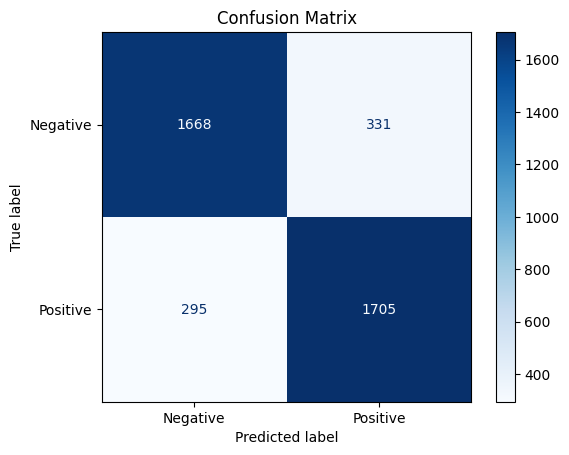

In [32]:
plot_confusion_matrix(all_labels_en, all_preds_en)

## German

In [33]:
train_loader_de, val_loader_de, test_loader_de = prepare_datasets(df_train_de, df_val_de, df_test_de)

Map:   0%|          | 0/160000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3999 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

In [34]:
model_de = prepare_model()

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


classifier.dense.weight
classifier.dense.bias
classifier.out_proj.weight
classifier.out_proj.bias


In [ ]:
train_model(model_de, train_loader_de, val_loader_de, 5, "./best_model_de.pt")

In [35]:
model_de.load_state_dict(torch.load("/kaggle/input/modelde/pytorch/default/1/best_model_de.pt"))

<All keys matched successfully>

In [36]:
all_labels_de, all_preds_de = test_model(model_de, test_loader_de)

Overall Accuracy: 0.869
Overall F1 Score: 0.8683417085427135
\nClassification Report:\n               precision    recall  f1-score   support

           0       0.87      0.87      0.87      2000
           1       0.87      0.86      0.87      2000

    accuracy                           0.87      4000
   macro avg       0.87      0.87      0.87      4000
weighted avg       0.87      0.87      0.87      4000

\n--- Per-Language Metrics ---
\nLanguage: de
  Selection rate: 0.4950
  Sapmoc accuracy: 0.8690
  Stat parity pos: 0.4950
  Stat parity neg: 0.5050
  Eq opp pos: 0.8640
  Eq opp neg: 0.8740
  Calib pos: 0.8727
  Calib neg: 0.8653
  Cue pos: 0.1273
  Cue neg: 0.1347
  Treat eq pos: 0.9265
  Treat eq neg: 1.0794
  Accuracy: 0.8690
  F1: 0.8683


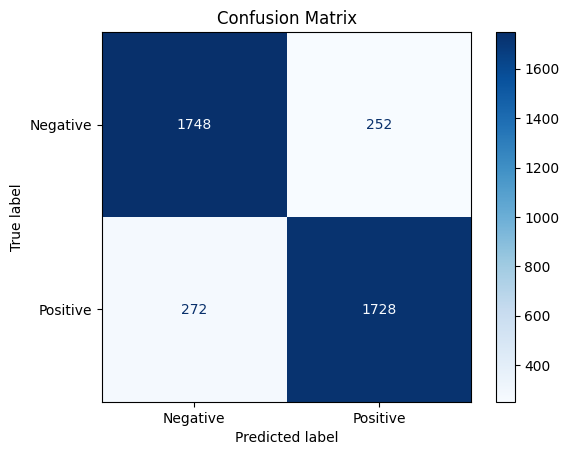

In [37]:
plot_confusion_matrix(all_labels_de, all_preds_de)

## Spanish

In [38]:
train_loader_es, val_loader_es, test_loader_es = prepare_datasets(df_train_es, df_val_es, df_test_es)

Map:   0%|          | 0/160000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

In [39]:
model_es = prepare_model()

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


classifier.dense.weight
classifier.dense.bias
classifier.out_proj.weight
classifier.out_proj.bias


In [21]:
train_model(model_es, train_loader_es, val_loader_es, 5, "/kaggle/input/esmodel/pytorch/default/1/best_model_es.pt")

/tmp/ipykernel_35/559945515.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1:   0%|          | 0/625 [00:00<?, ?it/s]/tmp/ipykernel_35/559945515.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # AMP context
Epoch 1: 100%|██████████| 625/625 [22:28<00:00,  2.16s/it, loss=0.663]


Epoch 1 - Training loss: 0.6775
Epoch 1 - Loss: 0.6775 | Val Acc: 0.8047 | Val F1: 0.8032
Best model saved (F1: 0.8032)


Epoch 2:   0%|          | 0/625 [00:00<?, ?it/s]/tmp/ipykernel_35/559945515.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # AMP context
Epoch 2: 100%|██████████| 625/625 [22:39<00:00,  2.18s/it, loss=0.614]


Epoch 2 - Training loss: 0.6430
Epoch 2 - Loss: 0.6430 | Val Acc: 0.8185 | Val F1: 0.8098
Best model saved (F1: 0.8098)


Epoch 3:   0%|          | 0/625 [00:00<?, ?it/s]/tmp/ipykernel_35/559945515.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # AMP context
Epoch 3: 100%|██████████| 625/625 [22:39<00:00,  2.18s/it, loss=0.599]


Epoch 3 - Training loss: 0.6090
Epoch 3 - Loss: 0.6090 | Val Acc: 0.8223 | Val F1: 0.8293
Best model saved (F1: 0.8293)


Epoch 4:   0%|          | 0/625 [00:00<?, ?it/s]/tmp/ipykernel_35/559945515.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # AMP context
Epoch 4: 100%|██████████| 625/625 [22:39<00:00,  2.17s/it, loss=0.565]


Epoch 4 - Training loss: 0.5818
Epoch 4 - Loss: 0.5818 | Val Acc: 0.8265 | Val F1: 0.8356
Best model saved (F1: 0.8356)


Epoch 5:   0%|          | 0/625 [00:00<?, ?it/s]/tmp/ipykernel_35/559945515.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # AMP context
Epoch 5: 100%|██████████| 625/625 [22:39<00:00,  2.18s/it, loss=0.53] 


Epoch 5 - Training loss: 0.5648
Epoch 5 - Loss: 0.5648 | Val Acc: 0.8393 | Val F1: 0.8437
Best model saved (F1: 0.8437)


In [40]:
model_es.load_state_dict(torch.load("/kaggle/input/esmodel/pytorch/default/1/best_model_es.pt"))

<All keys matched successfully>

In [41]:
all_labels_es, all_preds_es = test_model(model_es, test_loader_es)

Overall Accuracy: 0.843
Overall F1 Score: 0.8472019464720195
\nClassification Report:\n               precision    recall  f1-score   support

           0       0.86      0.82      0.84      2000
           1       0.83      0.87      0.85      2000

    accuracy                           0.84      4000
   macro avg       0.84      0.84      0.84      4000
weighted avg       0.84      0.84      0.84      4000

\n--- Per-Language Metrics ---
\nLanguage: es
  Selection rate: 0.5275
  Sapmoc accuracy: 0.8430
  Stat parity pos: 0.5275
  Stat parity neg: 0.4725
  Eq opp pos: 0.8705
  Eq opp neg: 0.8155
  Calib pos: 0.8251
  Calib neg: 0.8630
  Cue pos: 0.1749
  Cue neg: 0.1370
  Treat eq pos: 1.4247
  Treat eq neg: 0.7019
  Accuracy: 0.8430
  F1: 0.8472


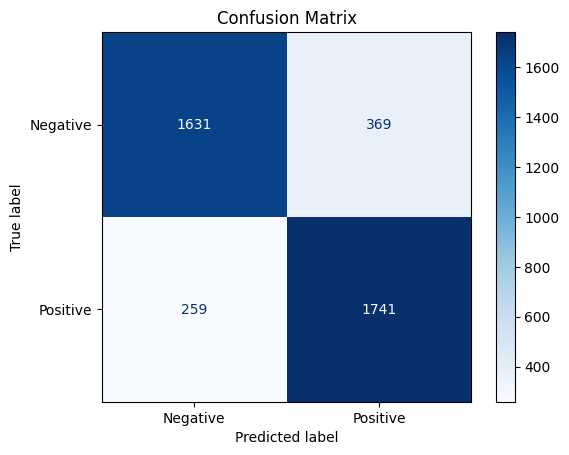

In [42]:
plot_confusion_matrix(all_labels_es, all_preds_es)

# Metrics for all languages

In [27]:
train_loader_en, val_loader_en, test_loader_en = prepare_datasets(df_train_en, df_val_en, df_test_en)
model_en = prepare_model()
model_en.load_state_dict(torch.load("/kaggle/input/model_en/pytorch/default/1/best_model_en.pt"))

Map:   0%|          | 0/159978 [00:00<?, ? examples/s]

Map:   0%|          | 0/3999 [00:00<?, ? examples/s]

Map:   0%|          | 0/3999 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


classifier.dense.weight
classifier.dense.bias
classifier.out_proj.weight
classifier.out_proj.bias


<All keys matched successfully>

In [28]:
train_loader_de, val_loader_de, test_loader_de = prepare_datasets(df_train_de, df_val_de, df_test_de)
model_de = prepare_model()
model_de.load_state_dict(torch.load("/kaggle/input/modelde/pytorch/default/1/best_model_de.pt"))

Map:   0%|          | 0/160000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3999 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


classifier.dense.weight
classifier.dense.bias
classifier.out_proj.weight
classifier.out_proj.bias


<All keys matched successfully>

In [29]:
train_loader_es, val_loader_es, test_loader_es = prepare_datasets(df_train_es, df_val_es, df_test_es)
model_es = prepare_model()
model_es.load_state_dict(torch.load("/kaggle/input/modeles/pytorch/default/1/best_model_es.pt"))

Map:   0%|          | 0/160000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


classifier.dense.weight
classifier.dense.bias
classifier.out_proj.weight
classifier.out_proj.bias


<All keys matched successfully>

In [30]:
all_labels_en, all_preds_en = test_model(model_en, test_loader_en)

Test Accuracy: 0.843460865216304
Test F1 Score: 0.8448959365708623
Fairness metrics skipped: only one group present.


In [31]:
all_labels_de, all_preds_de = test_model(model_de, test_loader_de)

Test Accuracy: 0.869
Test F1 Score: 0.8683417085427135
Fairness metrics skipped: only one group present.


In [32]:
all_labels_es, all_preds_es = test_model(model_es, test_loader_es)

Test Accuracy: 0.843
Test F1 Score: 0.8472019464720195
Fairness metrics skipped: only one group present.


In [38]:
all_labels = all_labels_es + all_labels_en + all_labels_de
all_preds = all_preds_es + all_preds_en + all_preds_de
group_labels = (["es"] * len(all_labels_es)) + (["en"] * len(all_labels_en)) + (["de"] * len(all_labels_de))


fairness(all_labels, all_preds, group_labels)



=== Metrics by Language Group ===
                     accuracy        f1  selection_rate
sensitive_feature_0                                    
de                   0.869000  0.868342        0.495000
en                   0.843461  0.844896        0.509127
es                   0.843000  0.847202        0.527500

=== Group Fairness Disparities ===
Statistical Parity Difference: 0.03249999999999997
Equality of Opportunity (TPR diff): 0.058499999999999996
False Positive Rate Difference: 0.058499999999999996
False Negative Rate Difference: 0.017999999999999988
True Positive Rate Difference: 0.018000000000000016
True Negative Rate Difference: 0.058499999999999996


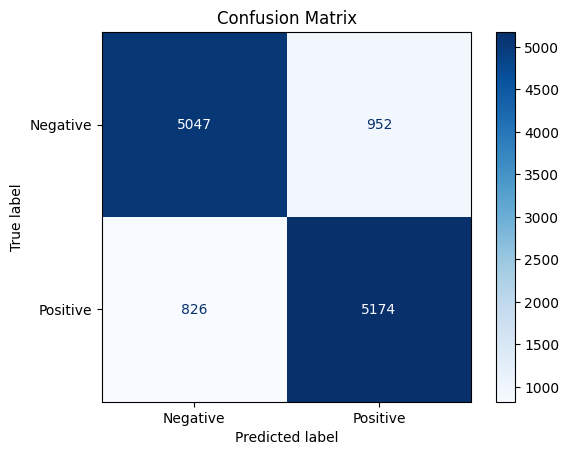

In [39]:
plot_confusion_matrix(all_labels, all_preds)

# Ensemble

In [43]:
model_specs = [
    ("bert", "bert-base-multilingual-cased", "/kaggle/input/modelbertde/pytorch/default/1/best_model_de_bert.pt"),
    ("distilbert", "distilbert-base-multilingual-cased", "/kaggle/input/modeldistilbertde/pytorch/default/1/best_model_de_distil_bert.pt"),
    ("xlm_roberta", "xlm-roberta-base", "/kaggle/input/modelde/pytorch/default/1/best_model_de.pt"),
]
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [44]:
def tokenize_function_test(example):
    tokenized = tokenizer(example['review'], truncation=True, padding="max_length", max_length=512)
    return tokenized


-------------------------

Evaluating metrics for model: bert


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


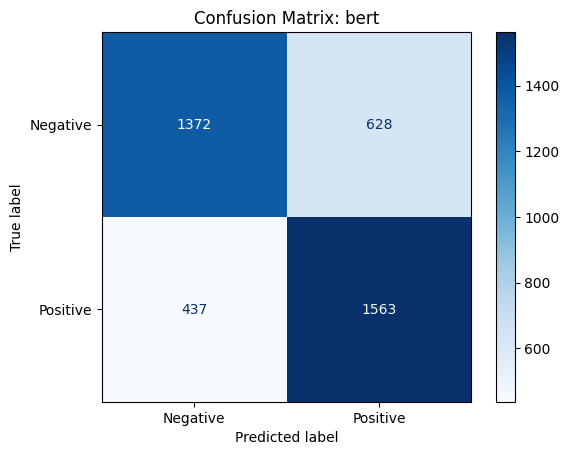


Fairness metrics for model: bert


,accuracy,f1_score
sensitive_feature_0,,
de,0.73375,0.745884



-------------------------

Evaluating metrics for model: distilbert


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


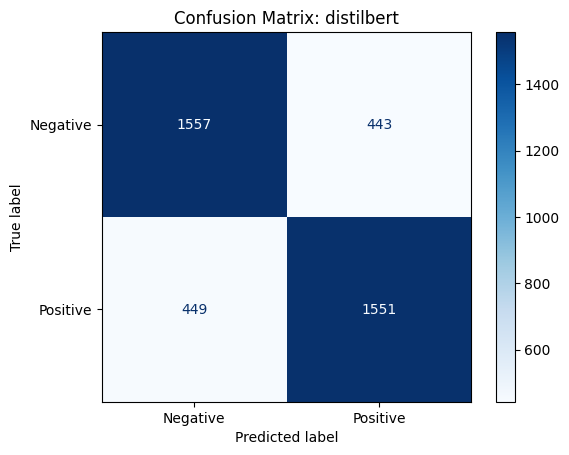


Fairness metrics for model: distilbert


,accuracy,f1_score
sensitive_feature_0,,
de,0.777,0.776665



-------------------------

Evaluating metrics for model: xlm_roberta


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


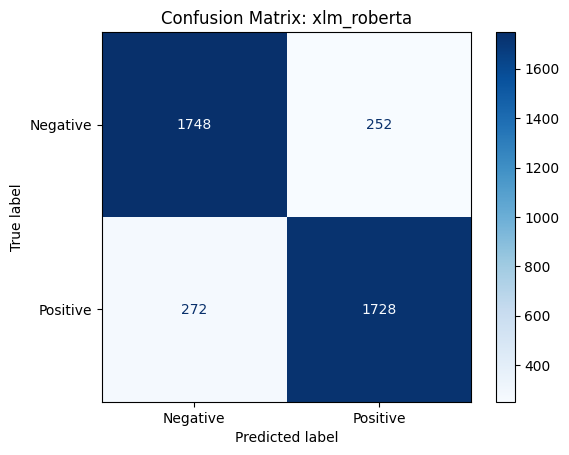


Fairness metrics for model: xlm_roberta


,accuracy,f1_score
sensitive_feature_0,,
de,0.869,0.868342



------------------------------
Evaluating Ensemble Model


In [45]:
from fairlearn.metrics import (
    MetricFrame,
    false_positive_rate,
    false_negative_rate,
    true_positive_rate,
    true_negative_rate,
    selection_rate,
    equalized_odds_difference,
    demographic_parity_difference
)
all_preds = []
true_labels = None
model_preds = {} 
results_table = []
spanish_only_preds = []
preds_logits = []

true_labels = df_test_de["label"].values
sensitive_features = df_test_de["language"].values

for model_id, model_name, model_path in model_specs:
    print("\n-------------------------")
    print(f"\nEvaluating metrics for model: {model_id}")
    tokenizer = AutoTokenizer.from_pretrained(model_name)


    test_dataset = Dataset.from_pandas(df_test_de.reset_index(drop=True))
    test_dataset = test_dataset.map(
        lambda e: tokenizer(e["review"], truncation=True, padding="max_length", max_length=512),
        batched=True
    )
    test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    preds = []
    labels = []

    logits_list = []
    with torch.no_grad():
        for batch in tqdm(test_loader, desc=f"Evaluating {model_id}", leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            pred = torch.argmax(outputs.logits, dim=-1)
            preds.extend(pred.cpu().numpy())
            logits_list.extend(outputs.logits.cpu().numpy())

    all_preds.append(np.array(preds))
    model_preds[model_id] = np.array(preds) 

    if model_id in ["bert", "distilbert", "xlm_roberta"]:
        spanish_only_preds.append(np.array(preds))
        preds_logits.append(np.array(logits_list))

    frame = MetricFrame(
        metrics={
            'accuracy': accuracy_score,
            'f1_score': f1_score,
        },
        y_true=true_labels,
        y_pred=preds,
        sensitive_features=sensitive_features
    )

    results_table.append({
        "model": model_id,
        "accuracy": frame.overall["accuracy"],
        "f1_score": frame.overall["f1_score"],
    })

    cm = confusion_matrix(true_labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title(f"Confusion Matrix: {model_id}")
    plt.show()

    print(f"\nFairness metrics for model: {model_id}")
    display(frame.by_group)

print("\n------------------------------\nEvaluating Ensemble Model")


Ensemble Model Performance
Accuracy: 0.8265
F1 Score : 0.8276


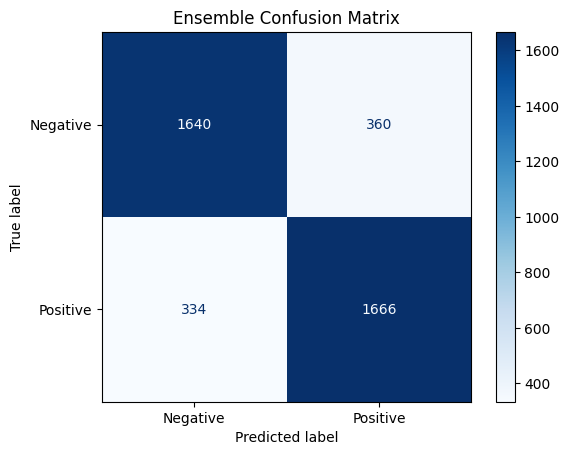


📊 Fairness metrics for Ensemble Model


,accuracy,f1_score
sensitive_feature_0,,
de,0.8265,0.82762


,model,accuracy,f1_score
0,bert,0.73375,0.745884
1,distilbert,0.77700,0.776665
2,xlm_roberta,0.86900,0.868342


{'selection_rate': 0.5065,
 'sapmoc_accuracy': 0.8265,
 'stat_parity_pos': 0.5065,
 'stat_parity_neg': 0.4935,
 'eq_opp_pos': 0.833,
 'eq_opp_neg': 0.82,
 'calib_pos': 0.8223099703849951,
 'calib_neg': 0.8308004052684904,
 'cue_pos': 0.17769002961500494,
 'cue_neg': 0.1691995947315096,
 'treat_eq_pos': 1.0778443113772456,
 'treat_eq_neg': 0.9277777777777778,
 'accuracy': 0.8265,
 'f1': 0.8276204669647294}

In [46]:
### ENSEMBLE MODEL
from scipy.stats import mode
# Majority voting
stacked_preds = np.stack(spanish_only_preds, axis=0)
majority_preds, _ = mode(stacked_preds, axis=0)
majority_preds = majority_preds.squeeze()
model_preds["ensemble"] = majority_preds

# Evaluate
acc = accuracy_score(true_labels, majority_preds)
f1 = f1_score(true_labels, majority_preds)

print(f"\nEnsemble Model Performance")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score : {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(true_labels, majority_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Ensemble Confusion Matrix")
plt.show()

# Ensemble Fairness Metrics
frame = MetricFrame(
    metrics={
        'accuracy': accuracy_score,
        'f1_score': f1_score,
    },
    y_true=true_labels,
    y_pred=majority_preds,
    sensitive_features=sensitive_features
)

print("\n📊 Fairness metrics for Ensemble Model")
display(frame.by_group)

results_df = pd.DataFrame(results_table)
display(results_df)


compute_group_metrics(true_labels, majority_preds)
